#Imports

In [ ]:
!pip install pennylane
!pip install pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 101.6 MB/s eta 0:00:00


In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# ML imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           roc_auc_score, f1_score, balanced_accuracy_score,
                           precision_recall_curve, average_precision_score)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Quantum imports
import pennylane as qml
from pennylane.templates import AngleEmbedding, AmplitudeEmbedding
from itertools import combinations  # For ZZ Feature Map

# Set visual style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set display options
pd.set_option('display.max_columns', None)

# 2. Enhanced Data Loading and Exploratory Analysis

Loading dataset...


<ipython-input-3-cc3e39b49ef4>:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Dataset loaded with 218,816 rows and 41 columns
Number of unique patients: 15,912

Adherence Score Statistics:
   Mean: 6.43
   Median: 7.00
   Min: 1.00
   Max: 12.00
   Std Dev: 3.94


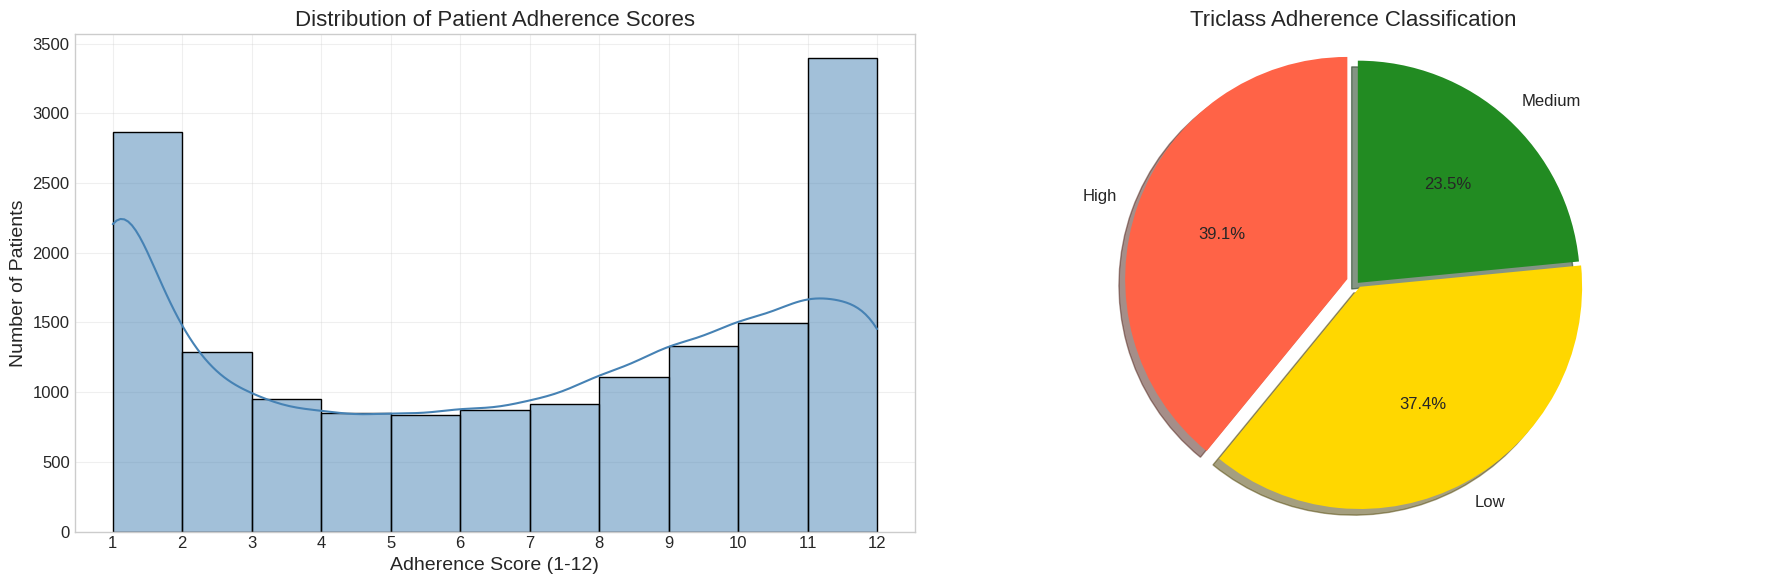

In [ ]:
# Load the hypertension dataset
filepath = '/content/HTN Adherence Data.csv'
print("Loading dataset...")
df = pd.read_csv(filepath)

print(f"Dataset loaded with {df.shape[0]:,} rows and {df.shape[1]} columns")
print(f"Number of unique patients: {df['MEMBER'].nunique():,}")

# Convert date columns to datetime format
date_columns = ['SERVICE DATE', 'ASSESS DATE', 'DATE RECEIVED', 'BIRTHDATE']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

# Basic statistics about adherence scores
adherence_stats = df.groupby('MEMBER')['ADHERENCE'].first().describe()
print("\nAdherence Score Statistics:")
print(f"   Mean: {adherence_stats['mean']:.2f}")
print(f"   Median: {adherence_stats['50%']:.2f}")
print(f"   Min: {adherence_stats['min']:.2f}")
print(f"   Max: {adherence_stats['max']:.2f}")
print(f"   Std Dev: {adherence_stats['std']:.2f}")

# Create interactive adherence score visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Distribution of adherence scores
member_adherence = df.groupby('MEMBER')['ADHERENCE'].first()
sns.histplot(member_adherence, bins=range(1, 13), kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Patient Adherence Scores')
axes[0].set_xlabel('Adherence Score (1-12)')
axes[0].set_ylabel('Number of Patients')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)

# Create 3-class adherence categories for pie chart
def adherence_category_label(score):
    if score <= 4:
        return 'Low'
    elif score <= 8:
        return 'Medium'
    else:
        return 'High'

adherence_categories = member_adherence.apply(adherence_category_label)
category_counts = adherence_categories.value_counts()

# Pie chart of adherence categories
axes[1].pie(category_counts.values,
        labels=category_counts.index,
        autopct='%1.1f%%',
        colors=['tomato', 'gold', 'forestgreen'],
        explode=(0.05, 0.02, 0),
        shadow=True,
        startangle=90)
axes[1].axis('equal')
axes[1].set_title('Triclass Adherence Classification')

plt.tight_layout()
plt.show()

#3. Enhanced Patient Feature Engineering


Creating patient-level features...


<ipython-input-4-98b8439b56c7>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
<ipython-input-4-98b8439b56c7>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
<ipython-input-4-98b8439b56c7>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This b

Created patient-level dataset with 15,912 patients and 28 features

Adherence category distribution (%):
Low (1-4) (class 0): 37.4%
Medium (5-8) (class 1): 23.5%
High (9-12) (class 2): 39.1%


<ipython-input-4-98b8439b56c7>:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADHERENCE_CATEGORY', y='AGE', data=patient_df,
<ipython-input-4-98b8439b56c7>:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADHERENCE_CATEGORY', y='UNIQUE_MEDS', data=patient_df,


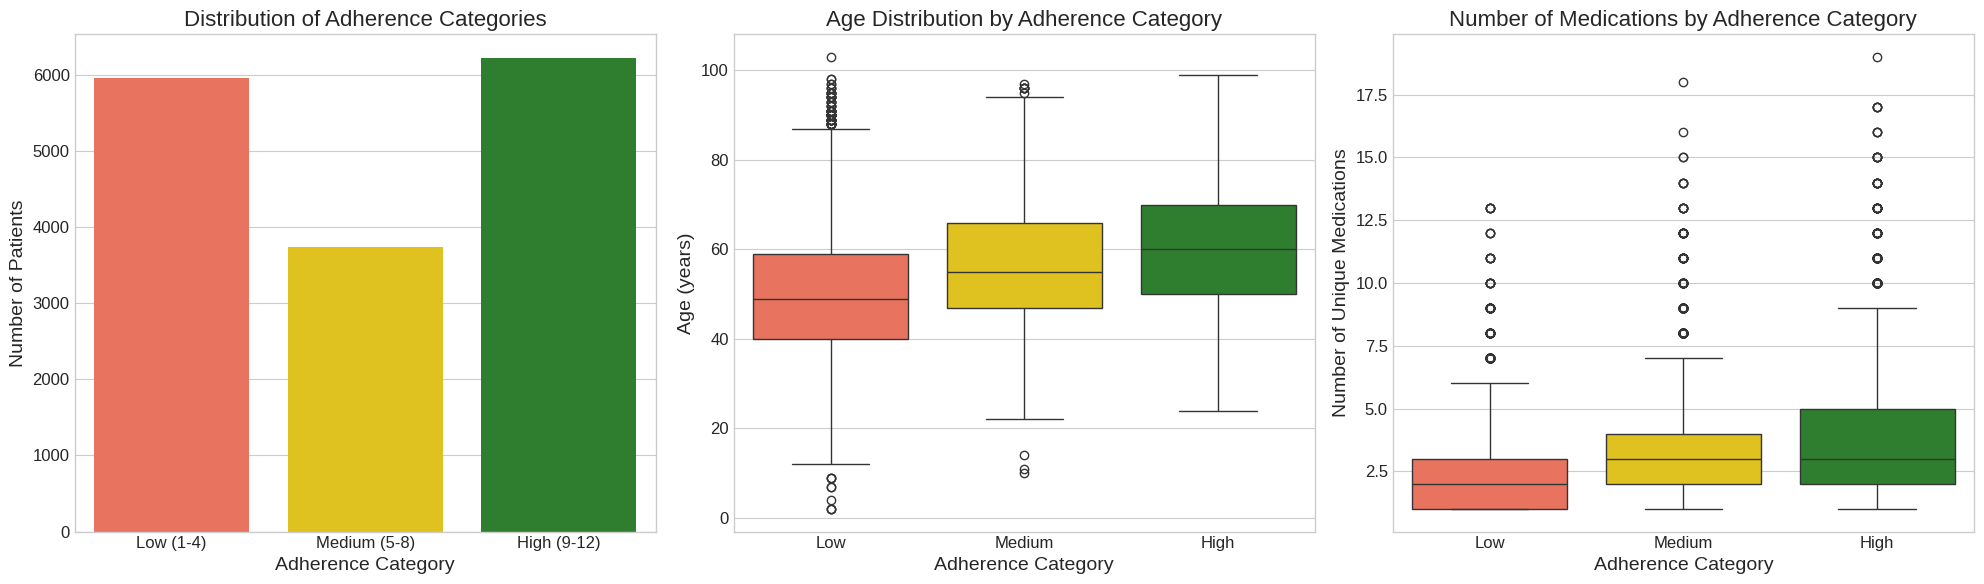

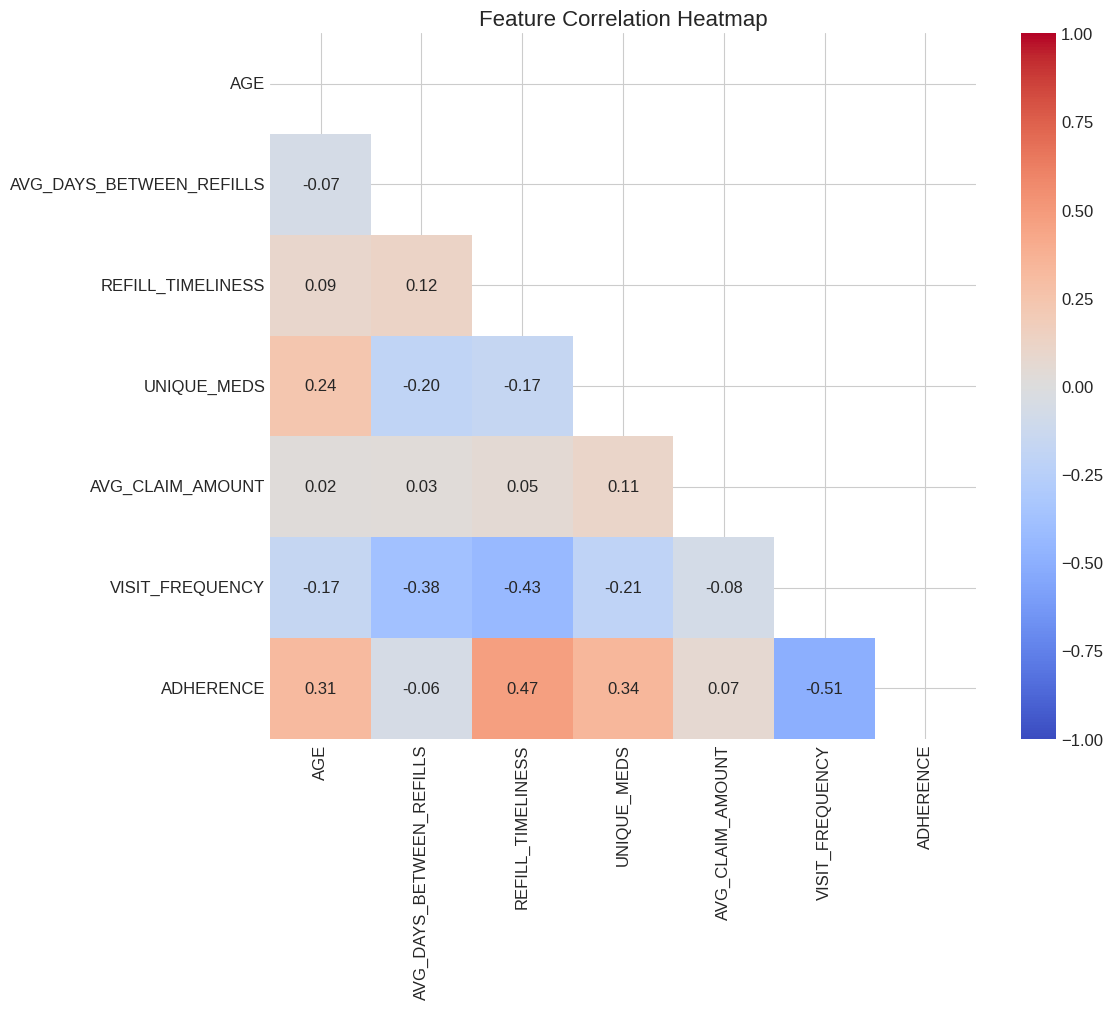

In [ ]:
def create_patient_features(df):
    """
    Create comprehensive patient-level features from transactional data.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data

    Returns:
    --------
    patient_df : pandas DataFrame
        Patient-level dataset with engineered features
    """
    print("Creating patient-level features...")

    # Group by patient
    patient_groups = df.groupby('MEMBER')

    # Basic demographic and adherence info
    patient_df = patient_groups.agg({
        'ADHERENCE': 'first',
        'GENDER': 'first',
        'CURRENT AGE': 'first',
        'OPTION NAME': 'first'
    }).rename(columns={'CURRENT AGE': 'AGE'})

    # Create age groups for better stratification
    age_bins = [0, 30, 40, 50, 60, 70, 80, 100]
    age_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    patient_df['AGE_GROUP'] = pd.cut(patient_df['AGE'], bins=age_bins, labels=age_labels)

    # Medical characteristics
    patient_df['UNIQUE_MEDS'] = patient_groups['CODE DESCRIPTION'].nunique()

    # Classify medications for hypertension - enhanced with more specific categories
    def classify_medication(description):
        if pd.isna(description):
            return 'Unknown'

        description = description.upper()

        # ACE Inhibitors
        if any(x in description for x in ['ENALAPRIL', 'LISINOPRIL', 'RAMIPRIL', 'PERINDOPRIL',
                                         'CAPTOPRIL', 'QUINAPRIL', 'TRANDOLAPRIL']):
            return 'ACE_Inhibitor'

        # Angiotensin II Receptor Blockers (ARBs)
        elif any(x in description for x in ['LOSARTAN', 'VALSARTAN', 'CANDESARTAN', 'IRBESARTAN',
                                           'TELMISARTAN', 'OLMESARTAN', 'EPROSARTAN']):
            return 'ARB'

        # Calcium Channel Blockers (CCBs)
        elif any(x in description for x in ['AMLODIPINE', 'NIFEDIPINE', 'FELODIPINE', 'DILTIAZEM',
                                           'VERAPAMIL', 'NIMODIPINE']):
            return 'CCB'

        # Diuretics
        elif any(x in description for x in ['HYDROCHLOROTHIAZIDE', 'CHLORTHALIDONE', 'INDAPAMIDE',
                                          'FUROSEMIDE', 'FRUSEMIDE', 'SPIRONOLACTONE']):
            return 'Diuretic'

        # Beta Blockers
        elif any(x in description for x in ['ATENOLOL', 'METOPROLOL', 'BISOPROLOL', 'CARVEDILOL',
                                          'NEBIVOLOL', 'SOTALOL']):
            return 'Beta_Blocker'

        # Combination Drugs
        elif any(x in description for x in ['TENORIC', 'EXFORGE', 'CO-DIOVAN', 'ZIAK']):
            return 'Combination'

        else:
            return 'Other'

    df['MED_CLASS'] = df['CODE DESCRIPTION'].apply(classify_medication)

    # Create medication class indicators
    med_classes = ['ACE_Inhibitor', 'ARB', 'CCB', 'Diuretic', 'Beta_Blocker', 'Combination', 'Other']
    for med_class in med_classes:
        patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
            lambda x: int((x['MED_CLASS'] == med_class).any())).values

    # Calculate financial patterns
    patient_df['AVG_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].mean()
    patient_df['TOTAL_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].sum()
    patient_df['NUM_CLAIMS'] = patient_groups.size()
    patient_df['AVG_UNITS'] = patient_groups['UNITS'].mean()

    # Calculate refill patterns
    def get_refill_stats(group):
        if len(group) <= 1:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0,
                'REFILL_TIMELINESS': 0
            })

        # Sort by date and calculate days between refills
        sorted_dates = group['SERVICE DATE'].sort_values()
        days_between = (sorted_dates.diff().dt.days.dropna())

        if len(days_between) == 0:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0,
                'REFILL_TIMELINESS': 0
            })

        avg_gap = days_between.mean()
        max_gap = days_between.max()

        # Coefficient of variation for regularity (lower is better)
        regularity = days_between.std() / avg_gap if avg_gap > 0 else 0

        # Timeliness score: percentage of refills within the expected window (30±7 days)
        on_time_refills = ((days_between >= 23) & (days_between <= 37)).mean()

        return pd.Series({
            'AVG_DAYS_BETWEEN_REFILLS': avg_gap,
            'MAX_GAP': max_gap,
            'REFILL_REGULARITY': regularity,
            'REFILL_TIMELINESS': on_time_refills
        })

    refill_stats = patient_groups.apply(get_refill_stats)
    patient_df = pd.concat([patient_df, refill_stats], axis=1)

    # Add visit frequency features
    patient_df['FIRST_VISIT'] = patient_groups['SERVICE DATE'].min()
    patient_df['LAST_VISIT'] = patient_groups['SERVICE DATE'].max()
    patient_df['OBSERVATION_PERIOD_DAYS'] = (patient_df['LAST_VISIT'] - patient_df['FIRST_VISIT']).dt.days
    patient_df['VISIT_FREQUENCY'] = patient_df['NUM_CLAIMS'] / (patient_df['OBSERVATION_PERIOD_DAYS'] + 1) * 30  # Visits per month

    # Add healthcare plan information
    plan_types = {
        'BASICARE': {'TYPE': 'STANDARD', 'COST': 'LOW'},
        'ICARE': {'TYPE': 'STANDARD', 'COST': 'MEDIUM'},
        'STUDYMATE PRIVATE': {'TYPE': 'SPECIAL', 'COST': 'LOW'},
        'PRIVATE HOSPITAL': {'TYPE': 'PREMIUM', 'COST': 'HIGH'},
        'PRIVATE HOSPITAL PLUS': {'TYPE': 'PREMIUM', 'COST': 'HIGH'}
    }

    patient_df['PLAN_TYPE'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('TYPE', 'STANDARD'))
    patient_df['PLAN_COST'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('COST', 'MEDIUM'))

    # Create adherence categories for 3-class classification
    def adherence_category(score):
        if score <= 4:
            return 0  # 'Low'
        elif score <= 8:
            return 1  # 'Medium'
        else:
            return 2  # 'High'

    patient_df['ADHERENCE_CATEGORY'] = patient_df['ADHERENCE'].apply(adherence_category)

    # Fill missing values
    numeric_cols = patient_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        patient_df[col] = patient_df[col].fillna(patient_df[col].median())

    return patient_df

# Create patient-level dataset
patient_df = create_patient_features(df)
print(f"Created patient-level dataset with {patient_df.shape[0]:,} patients and {patient_df.shape[1]} features")

# Check class distribution for 3-class adherence
adherence_counts = patient_df['ADHERENCE_CATEGORY'].value_counts(normalize=True) * 100
print("\nAdherence category distribution (%):")
adherence_labels = {0: "Low (1-4)", 1: "Medium (5-8)", 2: "High (9-12)"}
for category, percentage in sorted(adherence_counts.items()):
    print(f"{adherence_labels[category]} (class {category}): {percentage:.1f}%")

# Enhanced visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Distribution of adherence categories
sns.countplot(x='ADHERENCE_CATEGORY', data=patient_df,
              palette=['tomato', 'gold', 'forestgreen'],
              ax=axes[0])
axes[0].set_title('Distribution of Adherence Categories')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Low (1-4)', 'Medium (5-8)', 'High (9-12)'])
axes[0].set_ylabel('Number of Patients')
axes[0].set_xlabel('Adherence Category')

# Age distribution by adherence category
sns.boxplot(x='ADHERENCE_CATEGORY', y='AGE', data=patient_df,
            palette=['tomato', 'gold', 'forestgreen'],
            ax=axes[1])
axes[1].set_title('Age Distribution by Adherence Category')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Low', 'Medium', 'High'])
axes[1].set_ylabel('Age (years)')
axes[1].set_xlabel('Adherence Category')

# Medication counts by adherence category
sns.boxplot(x='ADHERENCE_CATEGORY', y='UNIQUE_MEDS', data=patient_df,
            palette=['tomato', 'gold', 'forestgreen'],
            ax=axes[2])
axes[2].set_title('Number of Medications by Adherence Category')
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels(['Low', 'Medium', 'High'])
axes[2].set_ylabel('Number of Unique Medications')
axes[2].set_xlabel('Adherence Category')

plt.tight_layout()
plt.show()

# Feature correlations with adherence
top_features = ['AGE', 'AVG_DAYS_BETWEEN_REFILLS', 'REFILL_TIMELINESS',
                'UNIQUE_MEDS', 'AVG_CLAIM_AMOUNT', 'VISIT_FREQUENCY']

# Create correlation plot for selected features
plt.figure(figsize=(12, 10))
feat_corr = patient_df[top_features + ['ADHERENCE']].corr()
mask = np.triu(np.ones_like(feat_corr, dtype=bool))
sns.heatmap(feat_corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, square=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

#4. Enhanced Feature Preparation and Visualization

Preparing features for classification...
Numeric features: 12
Categorical features: 4
Binary features: 7
Date features: 2
Training set size: 11,934, Test set size: 3,978
Preprocessed data shape: (11934, 37)
PCA explained variance: 0.8151


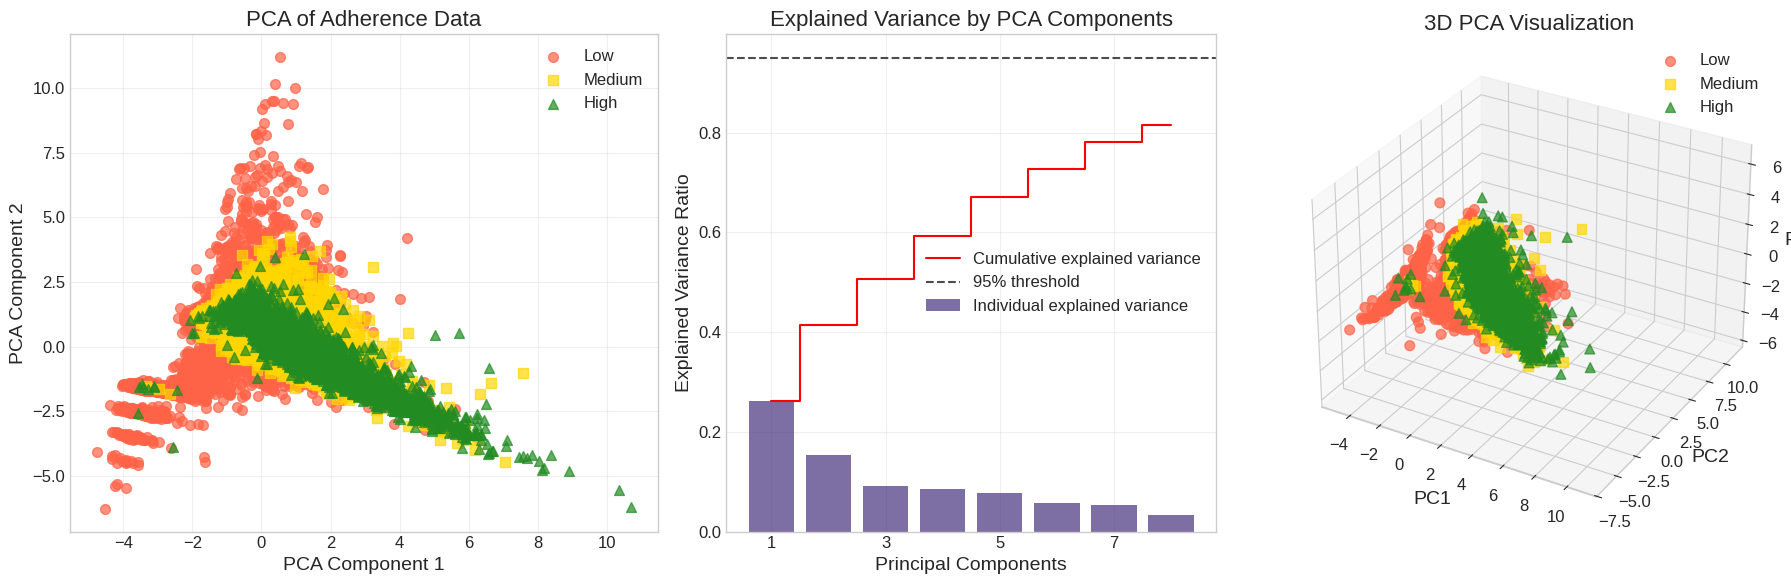

PCA data shape: (11934, 8)


In [ ]:
# Prepare data for multiclass classification
def prepare_features(patient_df):
    """
    Prepare features for multiclass classification with enhanced selection.

    Parameters:
    -----------
    patient_df : pandas DataFrame
        Patient-level dataset

    Returns:
    --------
    X : pandas DataFrame
        Feature matrix
    y : pandas Series
        Target variable
    feature_types : dict
        Dictionary containing lists of different feature types
    """
    print("Preparing features for classification...")

    # Remove direct adherence scores from features
    X = patient_df.drop(['ADHERENCE', 'ADHERENCE_CATEGORY'], axis=1)
    y = patient_df['ADHERENCE_CATEGORY']  # 3-class classification target

    # Identify feature types
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Boolean features (keeping as numeric)
    binary_features = [col for col in numeric_features if col.startswith('TAKES_')]

    # Remove binary features from numeric features list to handle them separately
    numeric_features = [col for col in numeric_features if col not in binary_features]

    # Remove date features from numeric features
    date_features = [col for col in X.columns if pd.api.types.is_datetime64_dtype(X[col])]
    numeric_features = [col for col in numeric_features if col not in date_features]

    feature_types = {
        'numeric': numeric_features,
        'categorical': categorical_features,
        'binary': binary_features,
        'date': date_features
    }

    return X, y, feature_types

X, y, feature_types = prepare_features(patient_df)

# Print feature information
print(f"Numeric features: {len(feature_types['numeric'])}")
print(f"Categorical features: {len(feature_types['categorical'])}")
print(f"Binary features: {len(feature_types['binary'])}")
print(f"Date features: {len(feature_types['date'])}")

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]:,}, Test set size: {X_test.shape[0]:,}")

# Create preprocessing pipeline for features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_types['numeric']),
        ('cat', categorical_transformer, feature_types['categorical']),
        ('bin', binary_transformer, feature_types['binary'])
    ],
    remainder='drop'  # Drop any columns not specified
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Preprocessed data shape: {X_train_preprocessed.shape}")

# Enhanced PCA visualization and processing
def apply_pca_and_visualize(X_train_preprocessed, X_test_preprocessed, y_train, y_test, n_components=8):
    """
    Apply PCA and visualize the results with enhanced plots.

    Parameters:
    -----------
    X_train_preprocessed : numpy array
        Preprocessed training features
    X_test_preprocessed : numpy array
        Preprocessed test features
    y_train : numpy array
        Training labels
    y_test : numpy array
        Test labels
    n_components : int
        Number of PCA components to retain

    Returns:
    --------
    X_train_normalized : numpy array
        Normalized training data for quantum processing
    X_test_normalized : numpy array
        Normalized test data for quantum processing
    """
    # For quantum processing, reduce dimensions with PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_preprocessed)
    X_test_pca = pca.transform(X_test_preprocessed)

    # Normalize to [0, 1] range for quantum encoding
    X_train_normalized = (X_train_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))
    X_test_normalized = (X_test_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))

    # Handle potential NaN values
    X_train_normalized = np.nan_to_num(X_train_normalized)
    X_test_normalized = np.nan_to_num(X_test_normalized)

    print(f"PCA explained variance: {sum(pca.explained_variance_ratio_):.4f}")

    # Enhanced PCA visualization
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1])

    # Plot 1: First two PCA components with class separation
    ax1 = plt.subplot(gs[0])
    colors = ['tomato', 'gold', 'forestgreen']
    markers = ['o', 's', '^']
    for i, class_label in enumerate([0, 1, 2]):
        mask = y_train == class_label
        ax1.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                  c=colors[i], marker=markers[i], s=50, alpha=0.7, label=f'Class {class_label}')
    ax1.set_title('PCA of Adherence Data')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.legend(labels=['Low', 'Medium', 'High'])
    ax1.grid(alpha=0.3)

    # Plot 2: Explained variance by component
    ax2 = plt.subplot(gs[1])
    variance_explained = pca.explained_variance_ratio_
    cum_variance = np.cumsum(variance_explained)
    ax2.bar(range(1, len(variance_explained) + 1), variance_explained,
           alpha=0.7, align='center', label='Individual explained variance')
    ax2.step(range(1, len(cum_variance) + 1), cum_variance, where='mid',
            label='Cumulative explained variance', color='red')
    ax2.axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% threshold')
    ax2.set_title('Explained Variance by PCA Components')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_xticks(range(1, len(variance_explained) + 1, 2))
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    # Plot 3: 3D visualization of first three components
    ax3 = plt.subplot(gs[2], projection='3d')

    for i, class_label in enumerate([0, 1, 2]):
        mask = y_train == class_label
        ax3.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], X_train_pca[mask, 2],
                   c=colors[i], marker=markers[i], alpha=0.7, s=50, label=f'Class {class_label}')

    ax3.set_title('3D PCA Visualization')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    ax3.set_zlabel('PC3')
    ax3.legend(labels=['Low', 'Medium', 'High'])

    plt.tight_layout()
    plt.show()

    return X_train_normalized, X_test_normalized, pca

# Apply PCA and visualize
X_train_normalized, X_test_normalized, pca = apply_pca_and_visualize(
    X_train_preprocessed, X_test_preprocessed, y_train, y_test, n_components=8
)
print(f"PCA data shape: {X_train_normalized.shape}")

# Convert to torch tensors for efficient quantum kernel computation
X_train_torch = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_normalized, dtype=torch.float32)

# 5. Enhanced Quantum Kernel Implementation

Setting up quantum device with 15 qubits...
Visualizing quantum circuits...


<ipython-input-6-6b0231a39242>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


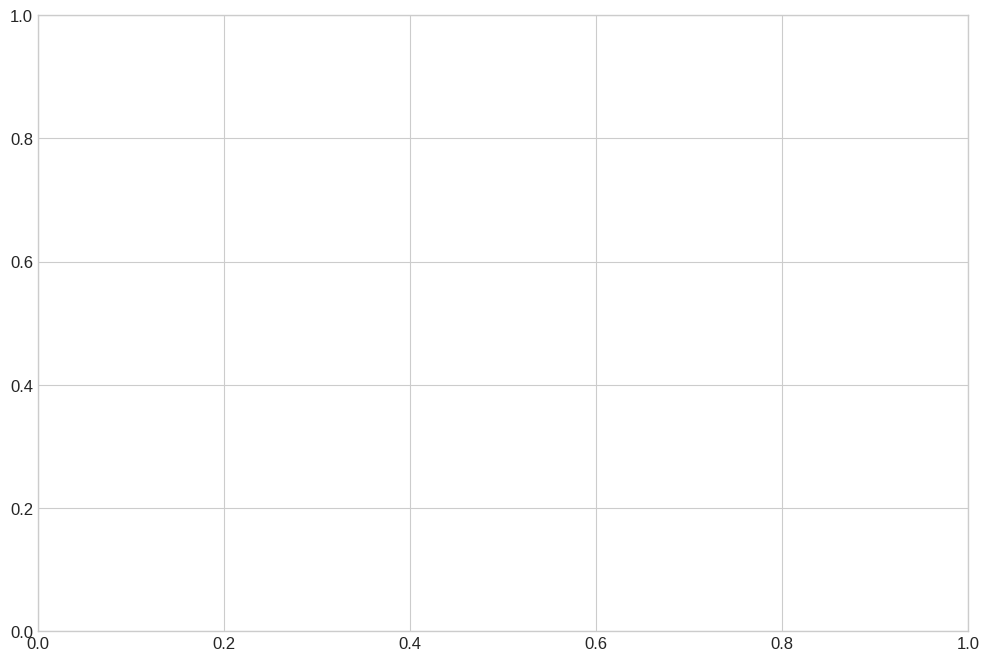

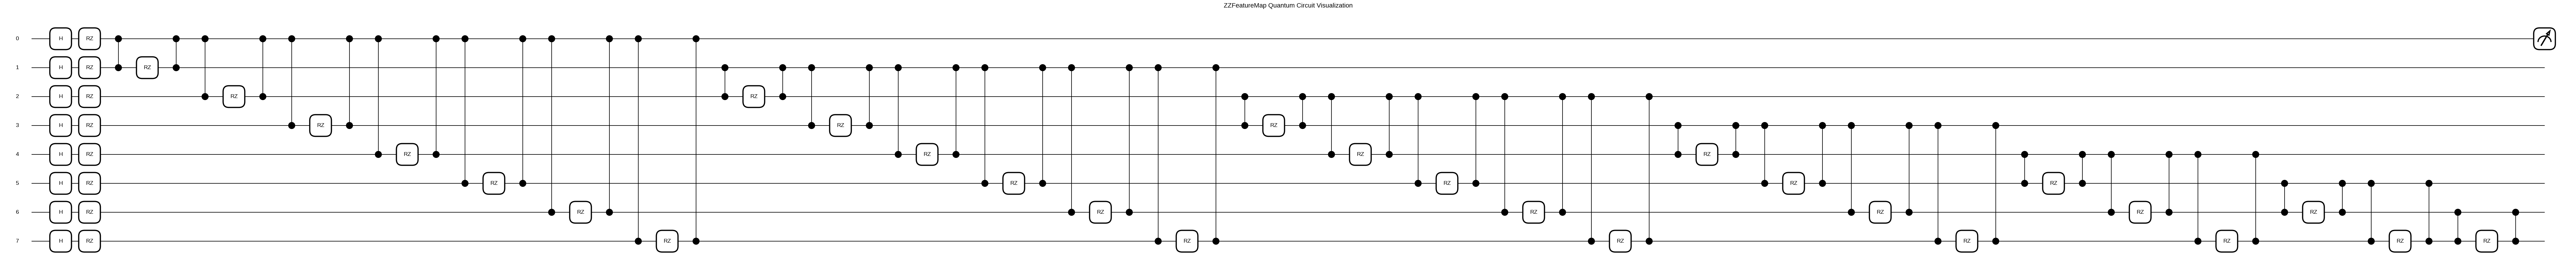

<ipython-input-6-6b0231a39242>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


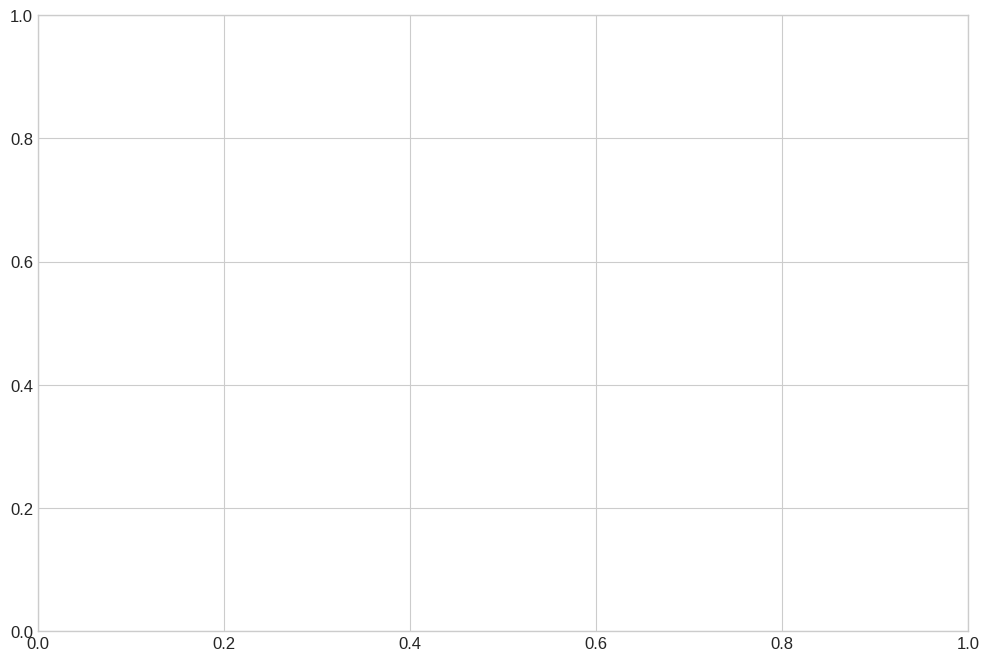

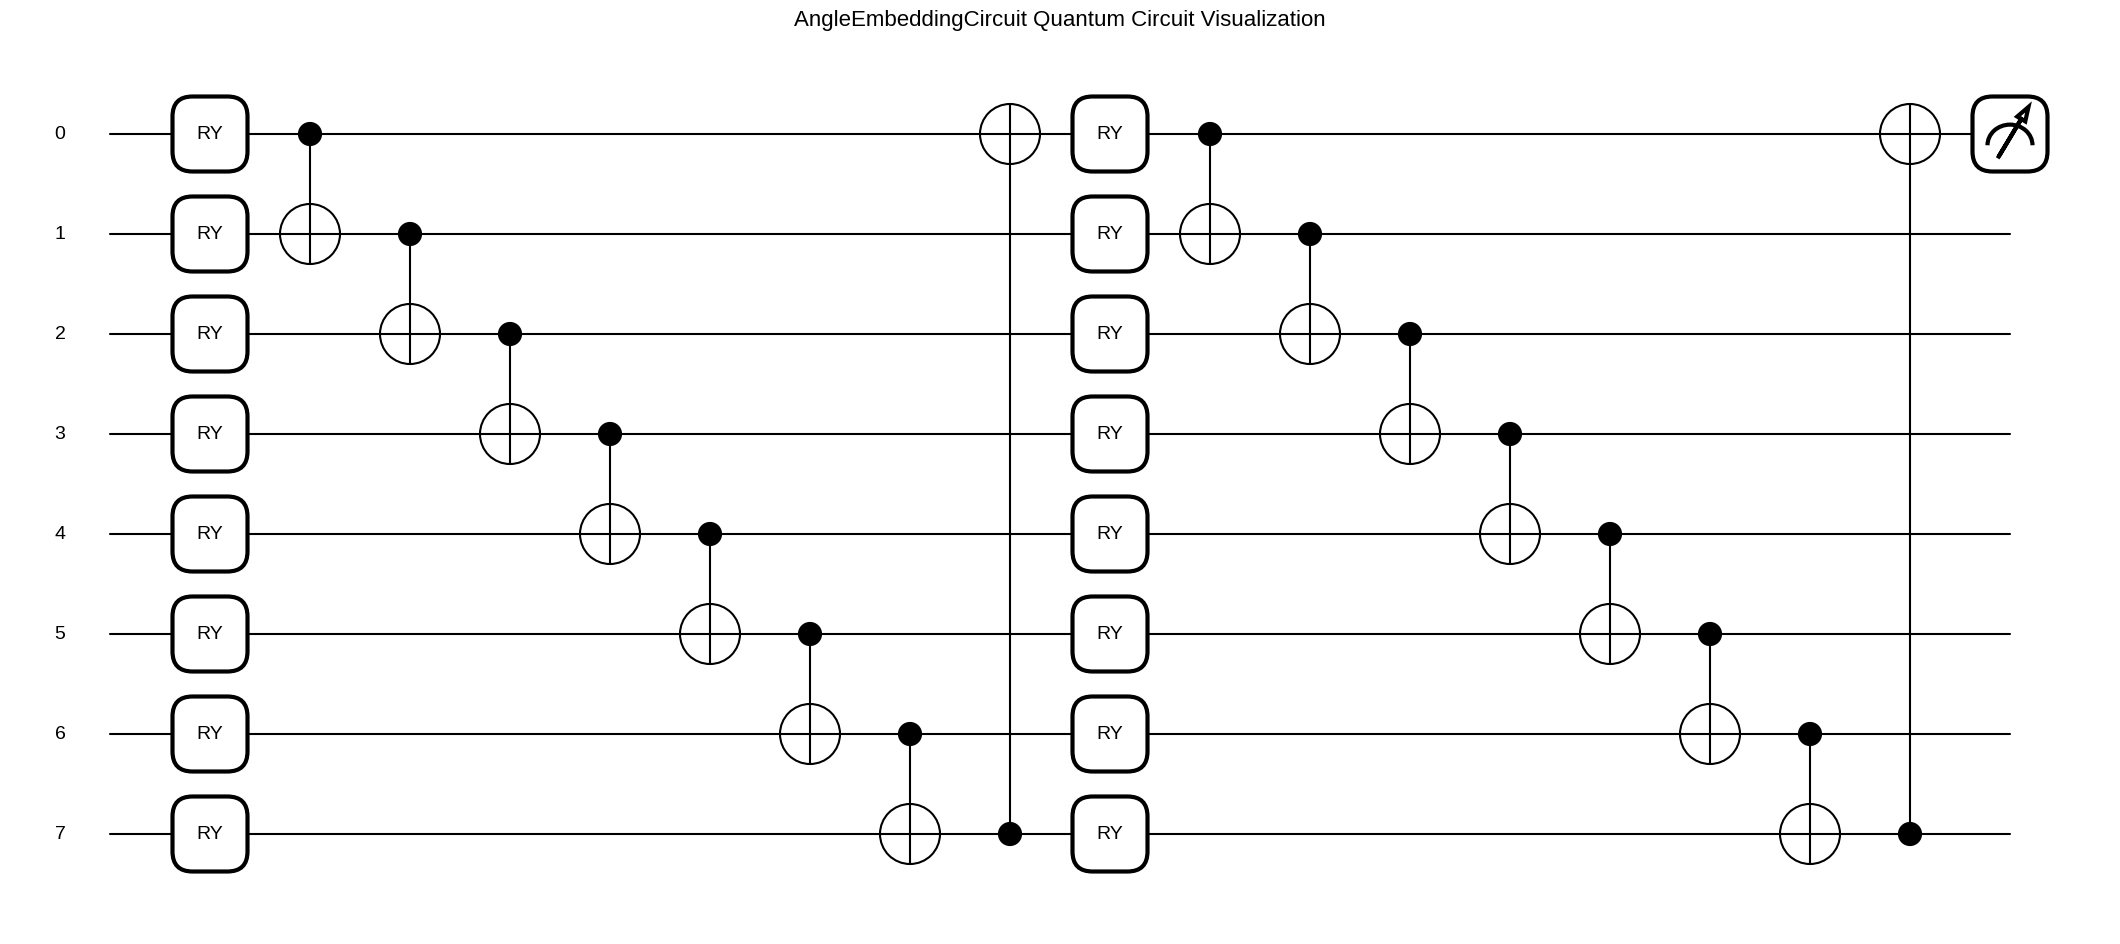

In [ ]:
# Initialize the quantum device with additional information
n_qubits = 15
print(f"Setting up quantum device with {n_qubits} qubits...")
dev = qml.device("lightning.qubit", wires=n_qubits)

def visualize_quantum_circuit(circuit_function, n_qubits, sample_data):
    """
    Visualize a quantum circuit using PennyLane's draw feature.

    Parameters:
    -----------
    circuit_function : function
        The quantum circuit function to visualize
    n_qubits : int
        Number of qubits
    sample_data : array
        Sample data point to encode
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Create a temporary circuit for visualization
    @qml.qnode(dev)
    def temp_circuit(x):
        circuit_function(n_qubits, x)
        return qml.expval(qml.PauliZ(0))

    # Draw the circuit
    circuit = qml.draw_mpl(temp_circuit)(sample_data)

    plt.title(f"{circuit_function.__name__} Quantum Circuit Visualization")
    plt.tight_layout()
    plt.show()

# Define ZZ Feature Map with improved entanglement
def ZZFeatureMap(nqubits, data, reps=1):
    """
    Implements an enhanced ZZ Feature Map with multiple repetitions for
    increased expressivity.

    Args:
        nqubits: Number of qubits
        data: Classical data vector to be encoded
        reps: Number of repetitions of the feature map
    """
    # Number of variables to load
    nload = min(len(data), nqubits)

    for r in range(reps):
        # First layer: Hadamard + rotation
        for i in range(nload):
            qml.Hadamard(wires=i)
            qml.RZ(2.0 * data[i], wires=i)

        # Second layer: Entangling with ZZ interactions
        for pair in list(combinations(range(nload), 2)):
            q0 = pair[0]
            q1 = pair[1]

            qml.CZ(wires=[q0, q1])
            qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires=q1)
            qml.CZ(wires=[q0, q1])

        # Add additional entangling layer if not last repetition
        if r < reps - 1:
            for i in range(0, nload-1, 2):
                if i+1 < nload:  # Ensure we don't go out of bounds
                    qml.CNOT(wires=[i, i+1])

# Define enhanced Angle Embedding circuit
def AngleEmbeddingCircuit(nqubits, data, reps=2):
    """
    Implements an enhanced Angle Embedding with multiple repetitions and
    entanglement layers for increased expressivity.

    Args:
        nqubits: Number of qubits
        data: Classical data vector to be encoded
        reps: Number of repetitions of the embedding
    """
    # Number of variables to load
    nload = min(len(data), nqubits)

    for r in range(reps):
        # Angle embedding layer
        for i in range(nload):
            qml.RY(np.pi * data[i], wires=i)

        # Entangling layer
        for i in range(nload-1):
            qml.CNOT(wires=[i, i+1])

        # Add ring entanglement if there are enough qubits
        if nload > 2:
            qml.CNOT(wires=[nload-1, 0])

# Visualize both quantum circuits with sample data
print("Visualizing quantum circuits...")
sample_data = X_train_normalized[0]
visualize_quantum_circuit(ZZFeatureMap, n_qubits, sample_data)
visualize_quantum_circuit(AngleEmbeddingCircuit, n_qubits, sample_data)

# Define ZZ Feature Map circuit
@qml.qnode(dev, interface="torch")
def zz_state_circuit(x):
    """Return quantum state after ZZ feature map embedding."""
    ZZFeatureMap(n_qubits, x)
    return qml.state()

# Define Angle Embedding circuit
@qml.qnode(dev, interface="torch")
def angle_state_circuit(x):
    """Return quantum state after angle embedding with repetitions."""
    AngleEmbeddingCircuit(n_qubits, x)
    return qml.state()

# Function to compute kernel matrices using the quantum states
def compute_kernel_matrices(circuit, X_train, X_test, name="Quantum Circuit"):
    """
    Compute training and test kernel matrices using the given quantum circuit.

    Args:
        circuit: The quantum circuit function for state preparation
        X_train: Training data as torch tensor
        X_test: Test data as torch tensor
        name: Name of the circuit for progress reporting

    Returns:
        K_train_np: Training kernel matrix as numpy array
        K_test_np: Test kernel matrix as numpy array
    """
    print(f"Computing quantum states for {name} training data...")
    states_train = []
    for x in tqdm(X_train):
        states_train.append(circuit(x))
    states_train = torch.stack(states_train)

    print(f"Computing quantum states for {name} test data...")
    states_test = []
    for x in tqdm(X_test):
        states_test.append(circuit(x))
    states_test = torch.stack(states_test)

    # Compute kernel matrices using the squared absolute value of inner products
    print("Computing kernel matrices...")
    K_train = torch.abs(states_train @ states_train.conj().transpose(0, 1)) ** 2
    K_test = torch.abs(states_test @ states_train.conj().transpose(0, 1)) ** 2

    # Convert to numpy arrays for scikit-learn
    K_train_np = K_train.detach().numpy()
    K_test_np = K_test.detach().numpy()

    return K_train_np, K_test_np

# 6. QSVM and Classical SVM Training and Evaluation


Computing kernel matrices with ZZ Feature Map...
Computing quantum states for ZZ Feature Map training data...


  0%|          | 0/11934 [00:00<?, ?it/s]

Computing quantum states for ZZ Feature Map test data...


  0%|          | 0/3978 [00:00<?, ?it/s]

Computing kernel matrices...

===== Training QSVM (ZZ Feature Map) for Multiclass Classification =====
Accuracy: 0.8032
Balanced Accuracy: 0.7928
Weighted F1 Score: 0.8085
Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.79      0.85      1490
      Medium       0.59      0.73      0.65       933
        High       0.86      0.86      0.86      1555

    accuracy                           0.80      3978
   macro avg       0.79      0.79      0.79      3978
weighted avg       0.82      0.80      0.81      3978



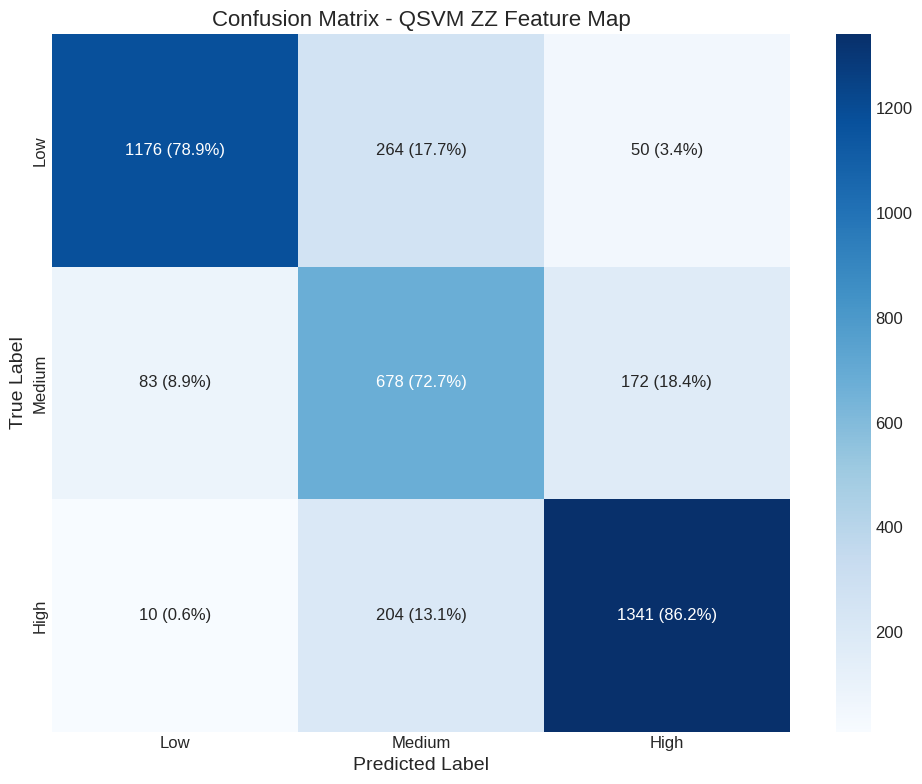

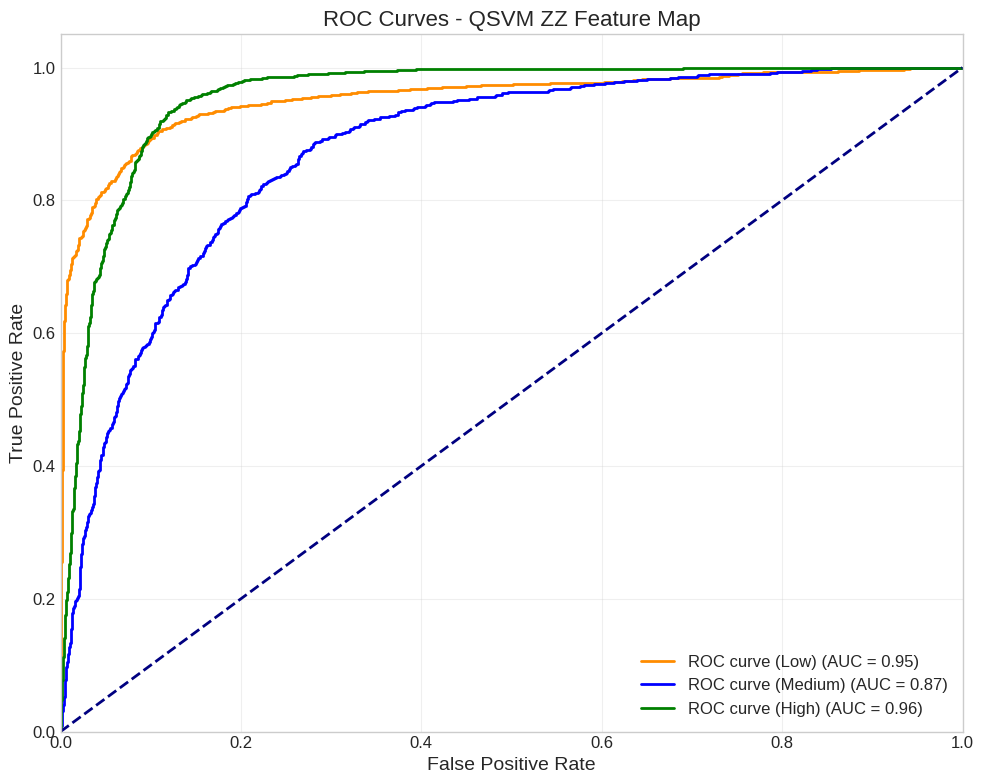


Computing kernel matrices with Angle Embedding...
Computing quantum states for Angle Embedding training data...


  0%|          | 0/11934 [00:00<?, ?it/s]

Computing quantum states for Angle Embedding test data...


  0%|          | 0/3978 [00:00<?, ?it/s]

Computing kernel matrices...

===== Training QSVM (Angle Embedding) for Multiclass Classification =====
Accuracy: 0.8731
Balanced Accuracy: 0.8655
Weighted F1 Score: 0.8752
Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.88      0.91      1490
      Medium       0.73      0.82      0.77       933
        High       0.90      0.90      0.90      1555

    accuracy                           0.87      3978
   macro avg       0.86      0.87      0.86      3978
weighted avg       0.88      0.87      0.88      3978



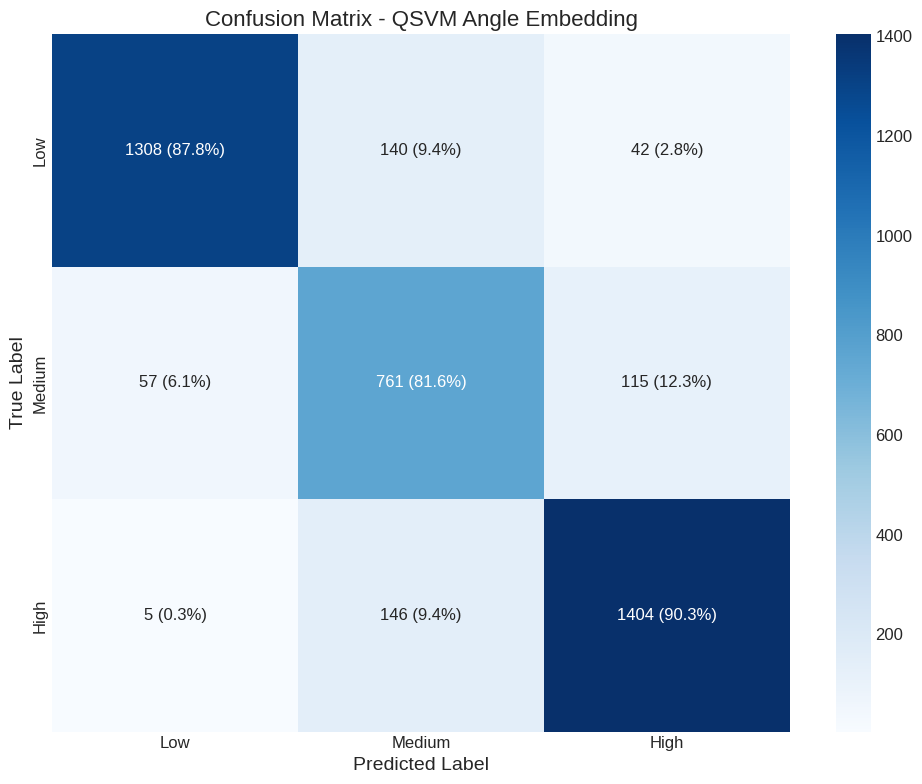

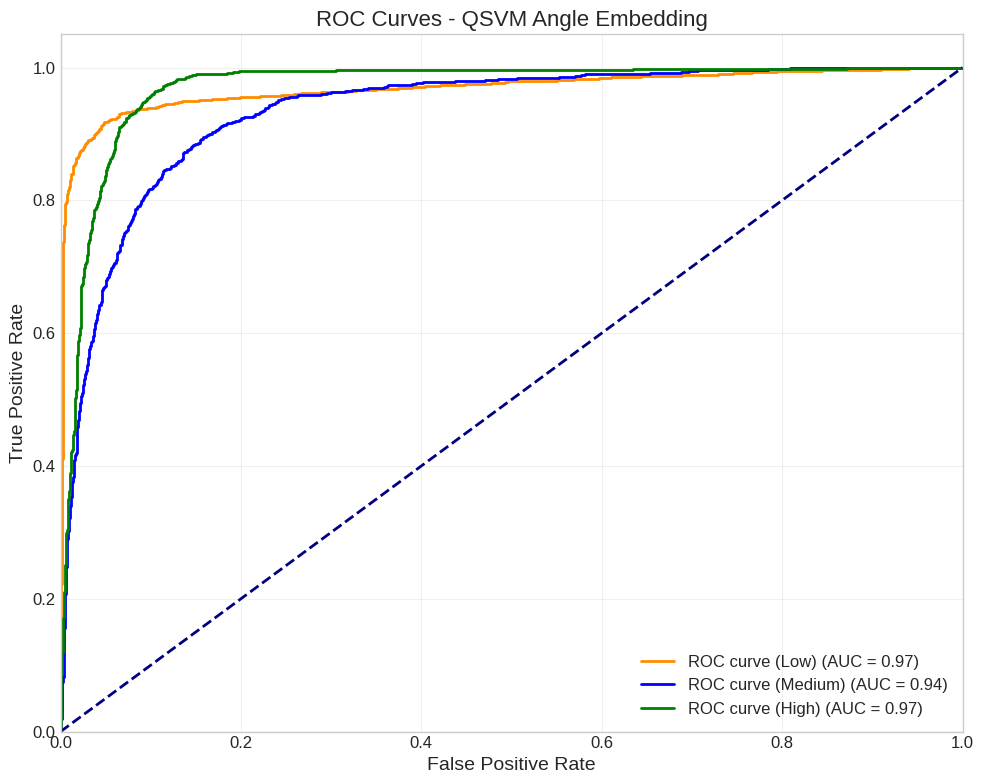


Training Classical SVM...

===== Training Classical SVM for Multiclass Classification =====
Accuracy: 0.8700
Balanced Accuracy: 0.8630
Weighted F1 Score: 0.8724
Classification Report:
              precision    recall  f1-score   support

         Low       0.96      0.87      0.91      1490
      Medium       0.72      0.82      0.76       933
        High       0.90      0.90      0.90      1555

    accuracy                           0.87      3978
   macro avg       0.86      0.86      0.86      3978
weighted avg       0.88      0.87      0.87      3978



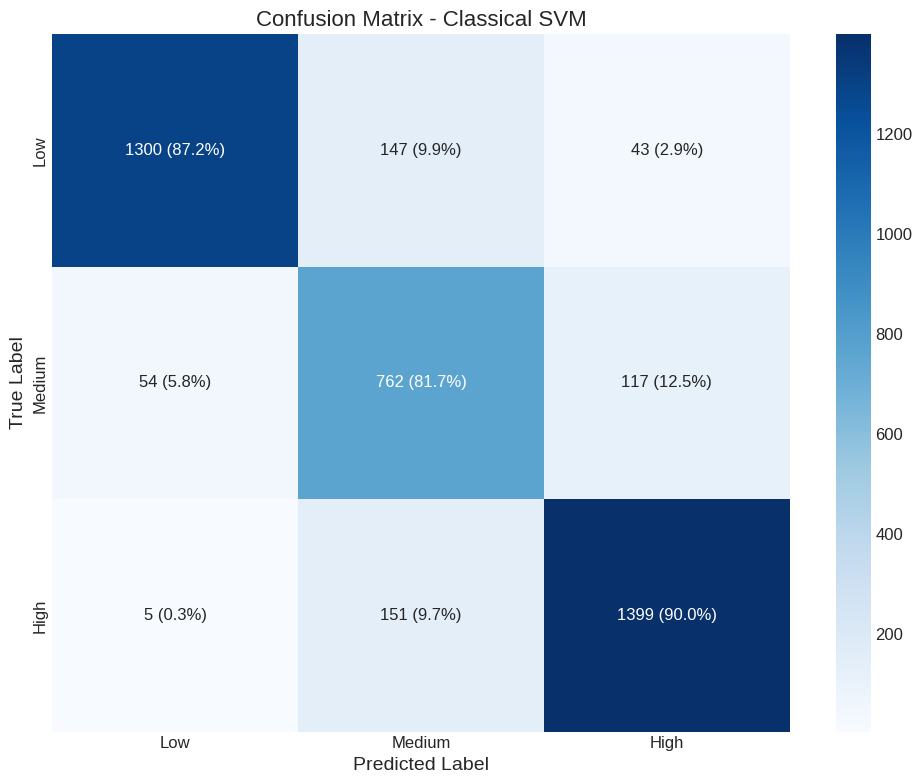

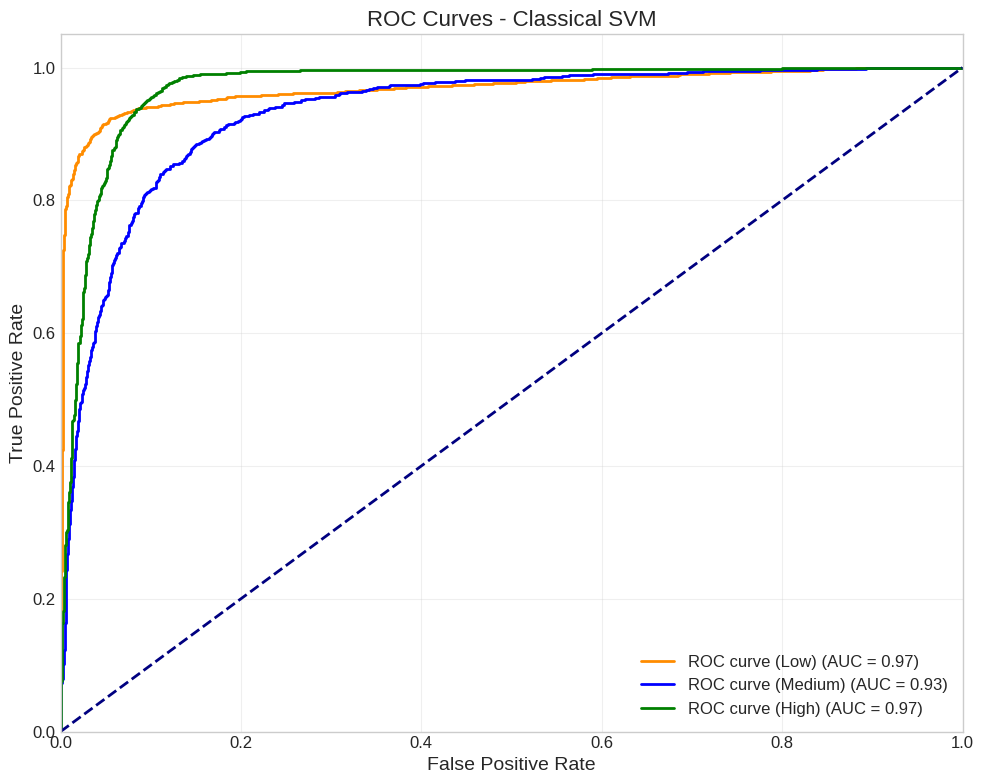

<ipython-input-8-e2bcdbc70a99>:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15),


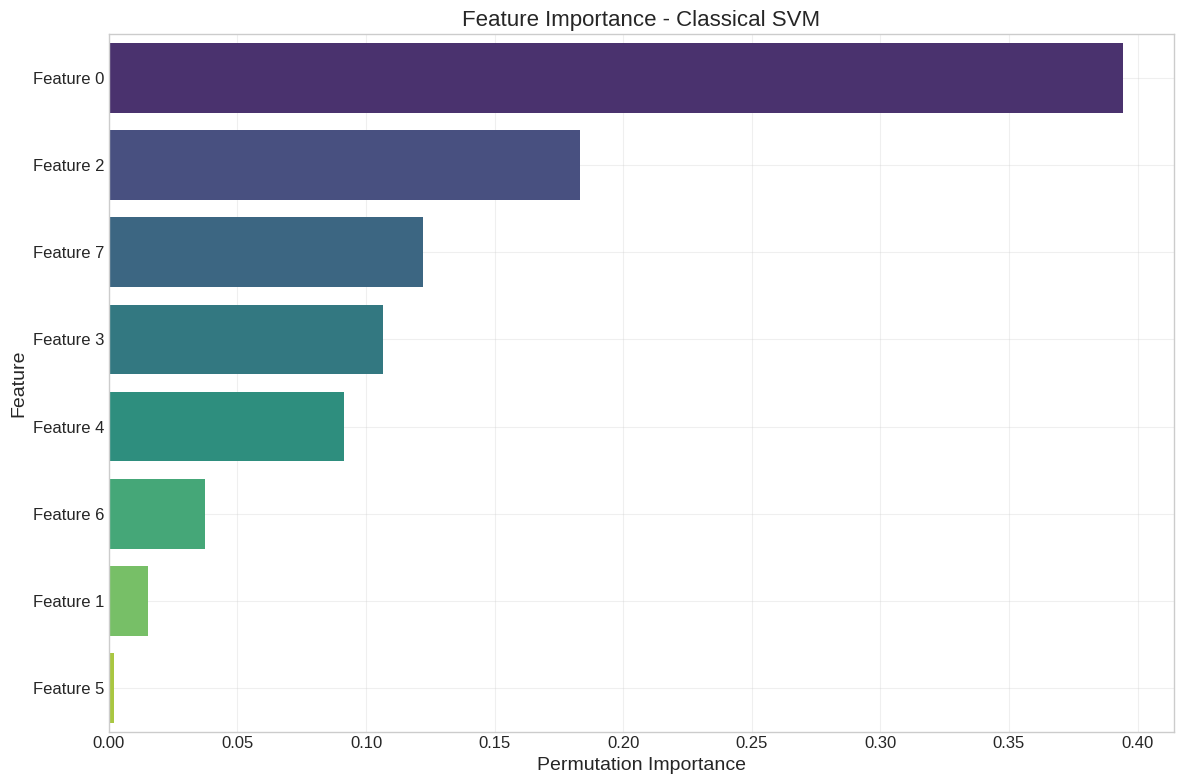

In [ ]:
# Function to train and evaluate QSVM models for multiclass classification
from sklearn.metrics import roc_curve
def train_evaluate_qsvm_multiclass(K_train, K_test, y_train, y_test, feature_map_name):
    """
    Train and evaluate QSVM with a given precomputed kernel for multiclass classification.

    Args:
        K_train: Training kernel matrix
        K_test: Test kernel matrix
        y_train: Training labels
        y_test: Test labels
        feature_map_name: Name of the feature map for reporting
    """
    print(f"\n===== Training QSVM ({feature_map_name}) for Multiclass Classification =====")

    # Train SVM with precomputed kernel
    qsvm = SVC(
        kernel="precomputed",
        decision_function_shape='ovr',  # one-vs-rest strategy
        C=1.0,
        probability=True,
        class_weight='balanced'
    )
    qsvm.fit(K_train, y_train)

    # Predict and evaluate
    y_pred = qsvm.predict(K_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

    # Create enhanced confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))

    # Calculate percentages for annotation
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f"{cm[i, j]} ({cm_perc[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f'Confusion Matrix - QSVM {feature_map_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()

    # For multiclass ROC curve, we need to binarize the data (one vs rest)
    n_classes = len(np.unique(y_test))
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and ROC area for each class
    y_pred_proba = qsvm.predict_proba(K_test)

    # Plot ROC curves
    fpr = {}
    tpr = {}
    roc_auc = {}
    colors = ['darkorange', 'blue', 'green']
    labels = ['Low', 'Medium', 'High']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test == i, y_pred_proba[:, i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve ({labels[i]}) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curves - QSVM {feature_map_name}', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return qsvm, accuracy, balanced_acc, f1_weighted, y_pred, y_pred_proba

# Train classical SVM for multiclass classification
def train_classical_svm_multiclass(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a classical SVM model for multiclass classification.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
    """
    print("\n===== Training Classical SVM for Multiclass Classification =====")

    # Parameter tuning (for production, consider using GridSearchCV here)
    classical_svm = SVC(
        kernel='rbf',
        decision_function_shape='ovr',
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced'
    )

    classical_svm.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = classical_svm.predict(X_test)
    y_pred_proba = classical_svm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

    # Create enhanced confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))

    # Calculate percentages for annotation
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f"{cm[i, j]} ({cm_perc[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Confusion Matrix - Classical SVM', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()

    # For multiclass ROC curve, we need to binarize the data (one vs rest)
    n_classes = len(np.unique(y_test))
    plt.figure(figsize=(10, 8))

    # Plot ROC curves
    fpr = {}
    tpr = {}
    roc_auc = {}
    colors = ['darkorange', 'blue', 'green']
    labels = ['Low', 'Medium', 'High']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test == i, y_pred_proba[:, i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve ({labels[i]}) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves - Classical SVM', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Feature importance through permutation importance
    if X_train.shape[1] <= 30:  # Only attempt if dimension is manageable
        try:
            result = permutation_importance(classical_svm, X_test, y_test, n_repeats=5,
                                          random_state=42, n_jobs=-1)

            # Create feature names based on positions
            feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]

            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': result.importances_mean,
                'Std': result.importances_std
            }).sort_values('Importance', ascending=False)

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15),
                       palette='viridis')
            plt.title('Feature Importance - Classical SVM', fontsize=16)
            plt.xlabel('Permutation Importance', fontsize=14)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        except:
            print("Skipping feature importance - computation too intensive for this dataset size")

    return classical_svm, accuracy, balanced_acc, f1_weighted, y_pred, y_pred_proba

# Compute and train models
print("\nComputing kernel matrices with ZZ Feature Map...")
K_train_zz, K_test_zz = compute_kernel_matrices(zz_state_circuit, X_train_torch, X_test_torch, "ZZ Feature Map")
qsvm_zz, acc_zz, bal_acc_zz, f1_zz, y_pred_zz, y_pred_proba_zz = train_evaluate_qsvm_multiclass(
    K_train_zz, K_test_zz, y_train, y_test, "ZZ Feature Map"
)

print("\nComputing kernel matrices with Angle Embedding...")
K_train_angle, K_test_angle = compute_kernel_matrices(angle_state_circuit, X_train_torch, X_test_torch, "Angle Embedding")
qsvm_angle, acc_angle, bal_acc_angle, f1_angle, y_pred_angle, y_pred_proba_angle = train_evaluate_qsvm_multiclass(
    K_train_angle, K_test_angle, y_train, y_test, "Angle Embedding"
)

print("\nTraining Classical SVM...")
classical_svm, acc_classical, bal_acc_classical, f1_classical, y_pred_classical, y_pred_proba_classical = train_classical_svm_multiclass(
    X_train_normalized, X_test_normalized, y_train, y_test
)

# 7. Enhanced Result Comparison and Analysis


Performing comprehensive model comparison and visualization...

Model Performance Comparison:
                 Model  Accuracy  Balanced Accuracy  F1 Score (weighted)
         Classical SVM  0.870035           0.862961             0.872404
 QSVM (ZZ Feature Map)  0.803167           0.792776             0.808521
QSVM (Angle Embedding)  0.873052           0.865465             0.875154


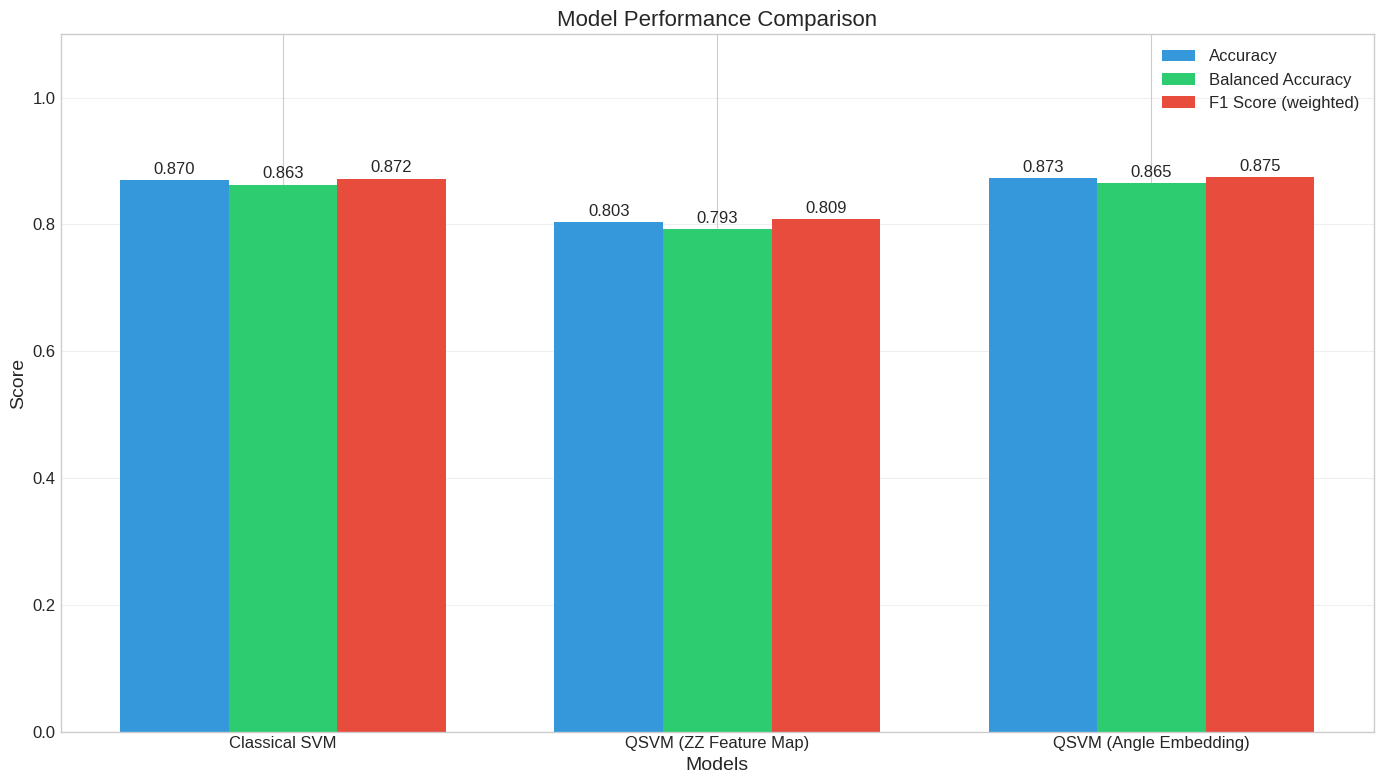


Class-wise Performance Comparison:
 Class  Classical Precision  ZZ Precision  Angle Precision  Classical Recall  ZZ Recall  Angle Recall  Classical F1    ZZ F1  Angle F1
   Low             0.956586      0.926714         0.954745          0.872483   0.789262      0.877852      0.912601 0.852483  0.914685
Medium             0.718868      0.591623         0.726839          0.816720   0.726688      0.815648      0.764676 0.652237  0.768687
  High             0.897370      0.857965         0.899423          0.899678   0.862379      0.902894      0.898523 0.860167  0.901155


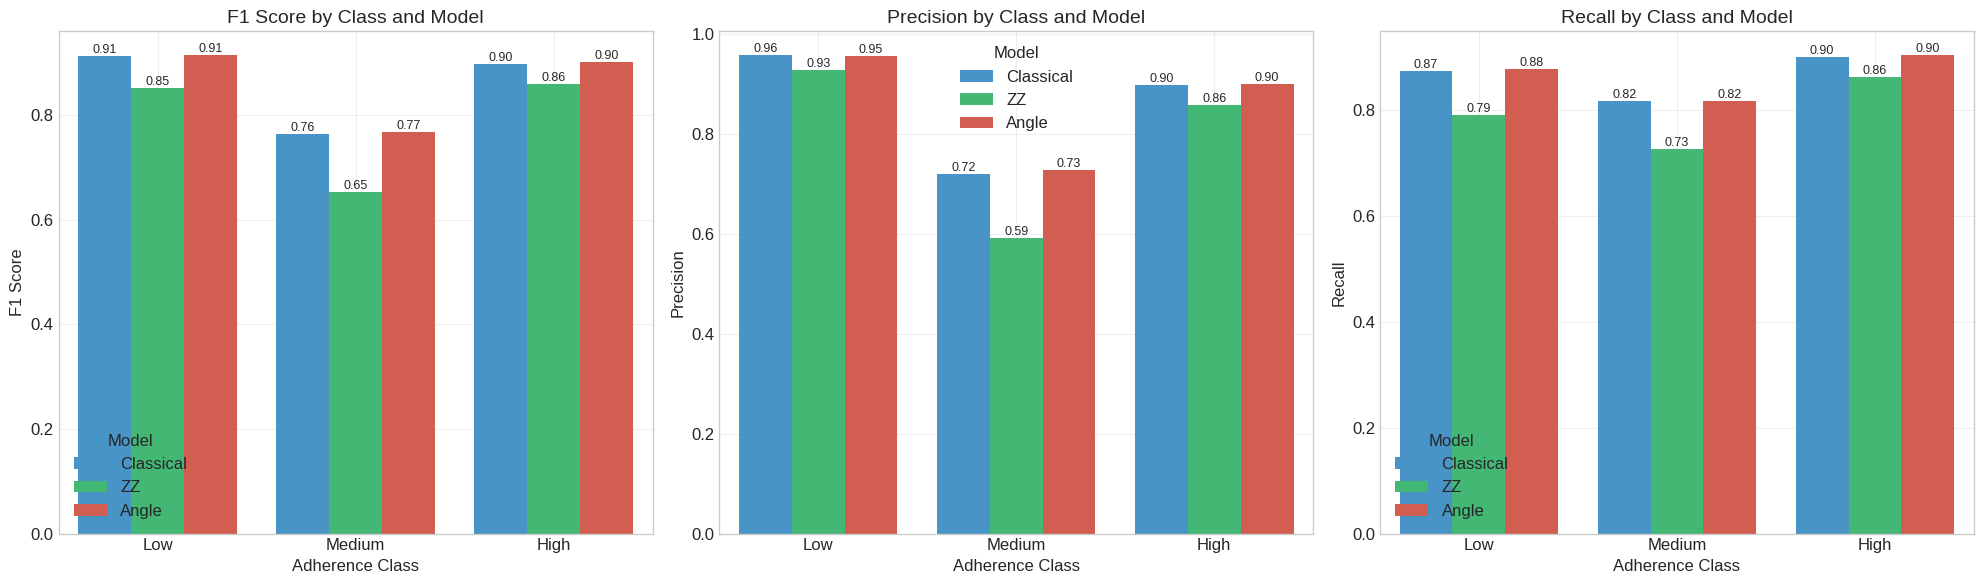

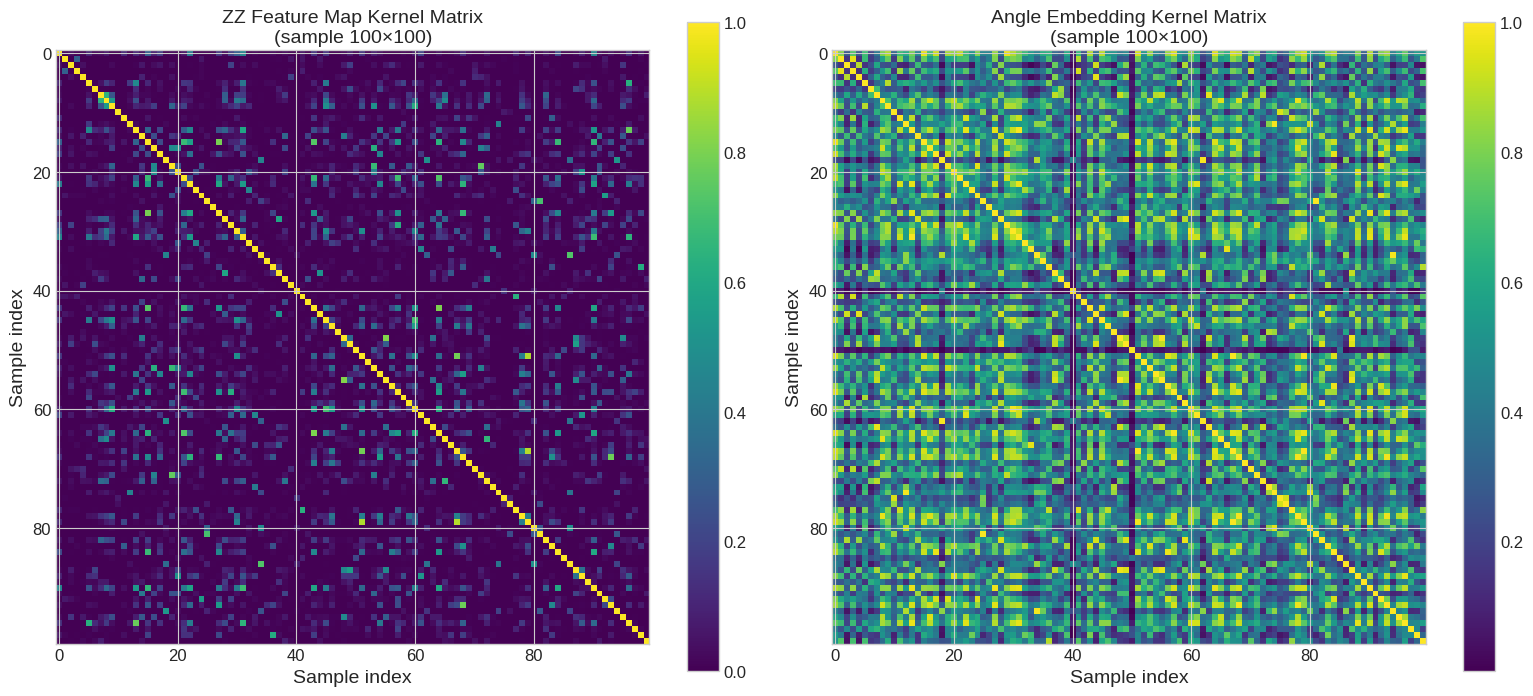


Model Agreement Analysis:
Classical SVM vs ZZ Feature Map: 0.8766 (87.7% agreement)
Classical SVM vs Angle Embedding: 0.9907 (99.1% agreement)
ZZ Feature Map vs Angle Embedding: 0.8733 (87.3% agreement)


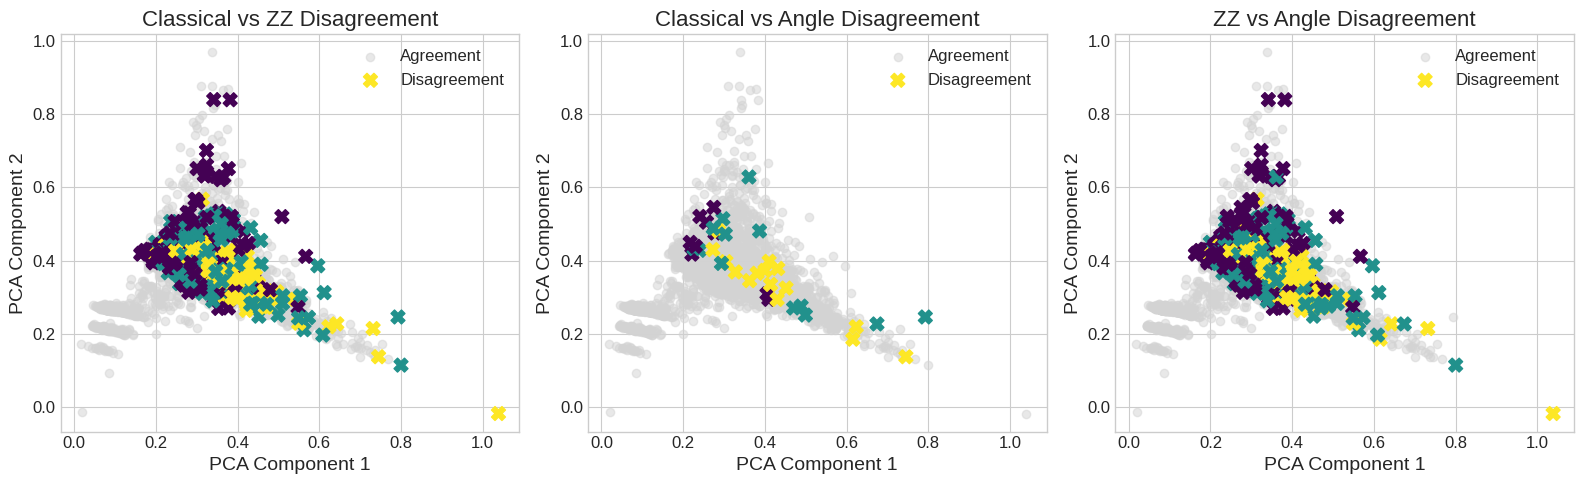

In [ ]:
def compare_models_multiclass(classical_metrics, zz_metrics, angle_metrics, class_names=['Low', 'Medium', 'High']):
    """
    Create comprehensive model comparison visualizations for multiclass classification.

    Args:
        classical_metrics: Tuple of metrics for classical SVM
        zz_metrics: Tuple of metrics for ZZ feature map QSVM
        angle_metrics: Tuple of metrics for angle embedding QSVM
        class_names: List of class names
    """
    # Unpack metrics
    acc_classical, bal_acc_classical, f1_classical, y_pred_classical, y_pred_proba_classical = classical_metrics
    acc_zz, bal_acc_zz, f1_zz, y_pred_zz, y_pred_proba_zz = zz_metrics
    acc_angle, bal_acc_angle, f1_angle, y_pred_angle, y_pred_proba_angle = angle_metrics

    # Create comparison dataframe
    models = ['Classical SVM', 'QSVM (ZZ Feature Map)', 'QSVM (Angle Embedding)']
    accuracies = [acc_classical, acc_zz, acc_angle]
    balanced_accs = [bal_acc_classical, bal_acc_zz, bal_acc_angle]
    f1_scores = [f1_classical, f1_zz, f1_angle]

    results_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'Balanced Accuracy': balanced_accs,
        'F1 Score (weighted)': f1_scores
    })

    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # Enhanced bar chart comparison
    plt.figure(figsize=(14, 8))
    x = np.arange(len(models))
    width = 0.25

    plt.bar(x - width, accuracies, width, label='Accuracy', color='#3498db')
    plt.bar(x, balanced_accs, width, label='Balanced Accuracy', color='#2ecc71')
    plt.bar(x + width, f1_scores, width, label='F1 Score (weighted)', color='#e74c3c')

    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Model Performance Comparison', fontsize=16)
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i in range(len(models)):
        plt.text(i - width, accuracies[i] + 0.01, f'{accuracies[i]:.3f}', ha='center')
        plt.text(i, balanced_accs[i] + 0.01, f'{balanced_accs[i]:.3f}', ha='center')
        plt.text(i + width, f1_scores[i] + 0.01, f'{f1_scores[i]:.3f}', ha='center')

    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

    # Per-class performance comparison
    class_report_classical = classification_report(y_test, y_pred_classical,
                                                target_names=class_names,
                                                output_dict=True)
    class_report_zz = classification_report(y_test, y_pred_zz,
                                          target_names=class_names,
                                          output_dict=True)
    class_report_angle = classification_report(y_test, y_pred_angle,
                                             target_names=class_names,
                                             output_dict=True)

    # Create class performance dataframes
    class_data = []
    for cls in class_names:
        class_data.append({
            'Class': cls,
            'Classical Precision': class_report_classical[cls]['precision'],
            'ZZ Precision': class_report_zz[cls]['precision'],
            'Angle Precision': class_report_angle[cls]['precision'],
            'Classical Recall': class_report_classical[cls]['recall'],
            'ZZ Recall': class_report_zz[cls]['recall'],
            'Angle Recall': class_report_angle[cls]['recall'],
            'Classical F1': class_report_classical[cls]['f1-score'],
            'ZZ F1': class_report_zz[cls]['f1-score'],
            'Angle F1': class_report_angle[cls]['f1-score'],
        })

    class_perf_df = pd.DataFrame(class_data)
    print("\nClass-wise Performance Comparison:")
    print(class_perf_df.to_string(index=False))

    # Create subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metrics = ['F1', 'Precision', 'Recall']
    titles = ['F1 Score', 'Precision', 'Recall']

    for i, metric in enumerate(metrics):
        metric_data = []
        for cls_idx, cls in enumerate(class_names):
            metric_data.append({
                'Class': cls,
                'Classical': class_perf_df[f'Classical {metric}'][cls_idx],
                'ZZ': class_perf_df[f'ZZ {metric}'][cls_idx],
                'Angle': class_perf_df[f'Angle {metric}'][cls_idx]
            })

        metric_df = pd.DataFrame(metric_data)

        # Reshape for seaborn
        metric_df_melted = pd.melt(
            metric_df,
            id_vars=['Class'],
            value_vars=['Classical', 'ZZ', 'Angle'],
            var_name='Model',
            value_name=metric
        )

        # Plot
        sns.barplot(x='Class', y=metric, hue='Model',
                  data=metric_df_melted,
                  palette=['#3498db', '#2ecc71', '#e74c3c'],
                  ax=axes[i])

        axes[i].set_title(f'{titles[i]} by Class and Model', fontsize=14)
        axes[i].set_xlabel('Adherence Class', fontsize=12)
        axes[i].set_ylabel(titles[i], fontsize=12)
        axes[i].grid(alpha=0.3)

        # Add value labels
        for j, container in enumerate(axes[i].containers):
            axes[i].bar_label(container, fmt='%.2f', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Visualize kernel matrices to compare structure
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Sample size for visualization
    sample_size = min(100, K_train_zz.shape[0])

    im0 = axes[0].imshow(K_train_zz[:sample_size, :sample_size], cmap='viridis')
    axes[0].set_title(f'ZZ Feature Map Kernel Matrix\n(sample {sample_size}×{sample_size})', fontsize=14)
    axes[0].set_xlabel('Sample index')
    axes[0].set_ylabel('Sample index')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(K_train_angle[:sample_size, :sample_size], cmap='viridis')
    axes[1].set_title(f'Angle Embedding Kernel Matrix\n(sample {sample_size}×{sample_size})', fontsize=14)
    axes[1].set_xlabel('Sample index')
    axes[1].set_ylabel('Sample index')
    fig.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Calculate agreement between models
    print("\nModel Agreement Analysis:")
    agreement_classical_zz = np.mean(y_pred_classical == y_pred_zz)
    agreement_classical_angle = np.mean(y_pred_classical == y_pred_angle)
    agreement_zz_angle = np.mean(y_pred_zz == y_pred_angle)

    print(f"Classical SVM vs ZZ Feature Map: {agreement_classical_zz:.4f} ({agreement_classical_zz*100:.1f}% agreement)")
    print(f"Classical SVM vs Angle Embedding: {agreement_classical_angle:.4f} ({agreement_classical_angle*100:.1f}% agreement)")
    print(f"ZZ Feature Map vs Angle Embedding: {agreement_zz_angle:.4f} ({agreement_zz_angle*100:.1f}% agreement)")

    # Create error analysis visualization
    plt.figure(figsize=(16, 5))

    # Collect samples where models disagree
    disagreement_mask_zz_classical = y_pred_zz != y_pred_classical
    disagreement_mask_angle_classical = y_pred_angle != y_pred_classical
    disagreement_mask_zz_angle = y_pred_zz != y_pred_angle

    plt.subplot(1, 3, 1)
    plt.scatter(X_test_normalized[~disagreement_mask_zz_classical, 0],
              X_test_normalized[~disagreement_mask_zz_classical, 1],
              c='lightgray', alpha=0.5, label='Agreement')
    plt.scatter(X_test_normalized[disagreement_mask_zz_classical, 0],
              X_test_normalized[disagreement_mask_zz_classical, 1],
              c=y_test[disagreement_mask_zz_classical], cmap='viridis',
              marker='X', s=100, label='Disagreement')
    plt.title('Classical vs ZZ Disagreement')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(X_test_normalized[~disagreement_mask_angle_classical, 0],
              X_test_normalized[~disagreement_mask_angle_classical, 1],
              c='lightgray', alpha=0.5, label='Agreement')
    plt.scatter(X_test_normalized[disagreement_mask_angle_classical, 0],
              X_test_normalized[disagreement_mask_angle_classical, 1],
              c=y_test[disagreement_mask_angle_classical], cmap='viridis',
              marker='X', s=100, label='Disagreement')
    plt.title('Classical vs Angle Disagreement')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.scatter(X_test_normalized[~disagreement_mask_zz_angle, 0],
              X_test_normalized[~disagreement_mask_zz_angle, 1],
              c='lightgray', alpha=0.5, label='Agreement')
    plt.scatter(X_test_normalized[disagreement_mask_zz_angle, 0],
              X_test_normalized[disagreement_mask_zz_angle, 1],
              c=y_test[disagreement_mask_zz_angle], cmap='viridis',
              marker='X', s=100, label='Disagreement')
    plt.title('ZZ vs Angle Disagreement')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Execute the comprehensive model comparison
print("\nPerforming comprehensive model comparison and visualization...")
compare_models_multiclass(
    (acc_classical, bal_acc_classical, f1_classical, y_pred_classical, y_pred_proba_classical),
    (acc_zz, bal_acc_zz, f1_zz, y_pred_zz, y_pred_proba_zz),
    (acc_angle, bal_acc_angle, f1_angle, y_pred_angle, y_pred_proba_angle),
    class_names=['Low', 'Medium', 'High']
)

# 8. Final Summary and Conclusions